In [15]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad
from scipy.special import kn, k0
from scipy.interpolate import splev, splrep

%matplotlib inline

# Set plot parameters to make beautiful plots
plt.rcParams['figure.figsize']  = 12, 7.5
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.family']     = 'serif'
plt.rcParams['font.weight']     = 'bold'
plt.rcParams['font.size']       = 20  
plt.rcParams['font.sans-serif'] = 'serif'
plt.rcParams['text.usetex']     = True
plt.rcParams['axes.linewidth']  = 1.5
plt.rcParams['axes.titlesize']  = 'medium'
plt.rcParams['axes.labelsize']  = 'medium'

plt.rcParams['xtick.major.size'] = 8     
plt.rcParams['xtick.minor.size'] = 4     
plt.rcParams['xtick.major.pad']  = 8     
plt.rcParams['xtick.minor.pad']  = 8     
plt.rcParams['xtick.color']      = 'k'     
plt.rcParams['xtick.labelsize']  = 'medium'
plt.rcParams['xtick.direction']  = 'in'    

plt.rcParams['ytick.major.size'] = 8     
plt.rcParams['ytick.minor.size'] = 4     
plt.rcParams['ytick.major.pad']  = 8     
plt.rcParams['ytick.minor.pad']  = 8     
plt.rcParams['ytick.color']      = 'k'     
plt.rcParams['ytick.labelsize']  = 'medium'
plt.rcParams['ytick.direction']  = 'in'    

In [16]:
# Anderson-Witting collision operator
# tau: relaxation time scale
tau = 0.1

N  = 16
Nt = 50
dx = 1./N
i  = np.arange(0, N, 1)
xGrid  = (i + 0.5)*dx
tFinal  = 5.
t  = np.linspace(0, tFinal, Nt)

amplitude  = 1e-3
k          = 2*np.pi
rho0        = 1.
pressure0   = 2.
uUp10       = 0.
Gamma       = 4/3

def rhoInit(x):
    return rho0 + 0.*amplitude*np.cos(k*x)

def pressureInit(x):
    return pressure0 + 0.*amplitude*np.cos(k*x)

def thetaInit(x):
    return pressureInit(x)/rhoInit(x)

def uUp1Init(x):
    return uUp10 + amplitude*np.cos(k*x)

In [17]:
def f0(pUp1, pPerp, x):    
    rho   = rhoInit(x)
    theta = thetaInit(x)
    uUp1  = uUp1Init(x)
    
    alpha = rho/(4.*np.pi*theta*kn(2, 1/theta))
    a0    = 1./theta
    
    uUp0 = np.sqrt(1. + uUp1**2.)
    uDown0 = -uUp0
    uDown1 = uUp1
    
    pUp0 = np.sqrt(1. + pUp1**2. + pPerp**2.) 
    
    return alpha*np.exp(a0*(pUp0*uDown0 + pUp1*uDown1) )

def f(p1, pPerp, x):
    tck = splrep(xGrid, f0(p1, pPerp, xGrid))
    
    df0_dx1 = splev(x, tck, der=1)
    
    p0 = np.sqrt(1. + p1**2. + pPerp**2.) 

    # Solution for Marle
    #return f0(p1, pPerp, x) - (tau * p1 * df0_dx1)

    # Solution for Anderson-Witting
    return f0(p1, pPerp, x) - (tau * p1/p0 * df0_dx1)

def integrand(p1, pPerp, x):
    
    # T^{01}: Heat flux
    #return p1 * (2.*np.pi*pPerp*f(p1, pPerp, x))
    
    # N^{1}: Matter flux
    #p0 = np.sqrt(1. + p1**2. + pPerp**2.)
    #return p1/p0 * (2.*np.pi*pPerp*f(p1, pPerp, x))
    
    # (T^{11} + T^{22} + T^{33})
    return (p1**2. + pPerp**2.) * (2.*np.pi*pPerp*f(p1, pPerp, x))

def marleKappa(tau, rho, theta):
    
    exp_of_alpha = rho/(4.*np.pi*theta*kn(2, 1/theta))
    
    return (tau*4.*np.pi*exp_of_alpha
            *(kn(4, 1/theta) - theta*kn(3, 1/theta) - (kn(3, 1/theta)**2./kn(2, 1/theta))) 
           )

def andersonWittingKappa(tau, rho, theta):
    
    exp_of_alpha = rho/(4.*np.pi*theta*kn(2, 1/theta))
    gamma = 1/theta
    h = kn(3, gamma)/kn(2, gamma)
    ki1 = quad(k0, gamma, np.inf)[0]
        
    return (tau*gamma**2./3.*4.*np.pi*exp_of_alpha*h
            * (h*(kn(2, gamma)/gamma + ki1 - kn(1, gamma)) - 3*kn(2, gamma)/gamma**2.)
           ) 
    
    #mu0 = (rho0 + pressure0/(Gamma-1))
    #A0 = 4*np.pi*exp_of_alpha*kn(1, gamma)/gamma
    #T1Bold = (1/3)*(4*rho0 - 4*np.pi*exp_of_alpha*(kn(1, gamma) - ki1) )
    #T2Bold = (1/3)*(rho0 - 4*np.pi*exp_of_alpha*(kn(1, gamma) - ki1) )
    #S1Bold = 2*mu0 - A0
    #S2Bold = (1/3)*(mu0 - A0)
    #S2     = 4*np.pi*exp_of_alpha*kn(3, gamma)/gamma**2.
    
    #return (tau*(mu0 + pressure0)/rho0*gamma**2. 
    #        * (T2Bold*S2/pressure0 - S2Bold)
    #       )

def marleZeta(tau, rho, theta):
    exp_of_alpha = rho/(4.*np.pi*theta*kn(2, 1/theta))
    gamma = 1/theta
    h = kn(3, gamma)/kn(2, gamma)
    hPrime = h**2. - (5/gamma)*h - 1
    Gamma = gamma**2.*hPrime/((gamma**2.*hPrime) + 1.)
    
    term1 =  1./((gamma**2.*hPrime)+1) \
            *(  kn(5, gamma)*(Gamma-1) \
              - kn(4, gamma)*(12*Gamma-13)/gamma \
              + kn(3, gamma)*(9*Gamma-10)/gamma**2. \
             )
        
    term2 = -(gamma*hPrime + h)/((gamma**2.*hPrime) + 1) \
            *(  kn(4, gamma)*(Gamma-1) \
              - kn(3, gamma)*(9*Gamma-10)/gamma \
             )
        
    term3 = 1/gamma \
            *(  kn(4, gamma)*(Gamma-1) \
              - kn(3, gamma)*(11*Gamma-38./3)/gamma \
             )
        
    return (tau*4*np.pi*exp_of_alpha*(term1 + term2 + term3))

In [18]:
soln = np.zeros(N)
for i in xrange(N):
    print "i = ", i
    integral = nquad(integrand, [[-np.inf, np.inf], [0, np.inf]], args=(xGrid[i],))
    soln[i]  = integral[0]

i =  0
i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15


In [19]:
T0_tck = splrep(xGrid, thetaInit(xGrid))
dT_dx1 = splev(xGrid, T0_tck, der=1)

uUp1_tck = splrep(xGrid, uUp1Init(xGrid))
uUp1_dx1 = splev(xGrid, uUp1_tck, der=1)


#print marleKappa(tau, np.mean(rhoInit(xGrid)), np.mean(thetaInit(xGrid)))
#print andersonWittingKappa(tau, np.mean(rhoInit(xGrid)), np.mean(thetaInit(xGrid)))
print marleZeta(tau, np.mean(rhoInit(xGrid)), np.mean(thetaInit(xGrid)))

# Marle thermal conductivity
#print np.mean(soln/-dT_dx1)

# Anderson-Witting thermal conduvitity
#print np.mean(soln/dT_dx1/(rhoInit(xGrid) + pressureInit(xGrid)/(5./3 - 1.) + pressureInit(xGrid) )/rhoInit(xGrid))

# Marle bulk viscosity
traceTmunu  = soln
traceT0munu = pressureInit(xGrid)
zeta = np.mean((-1/3) * (traceTmunu - traceT0munu)/(-uUp1_dx1))
print zeta

0.00021034819054
-2.73980202002


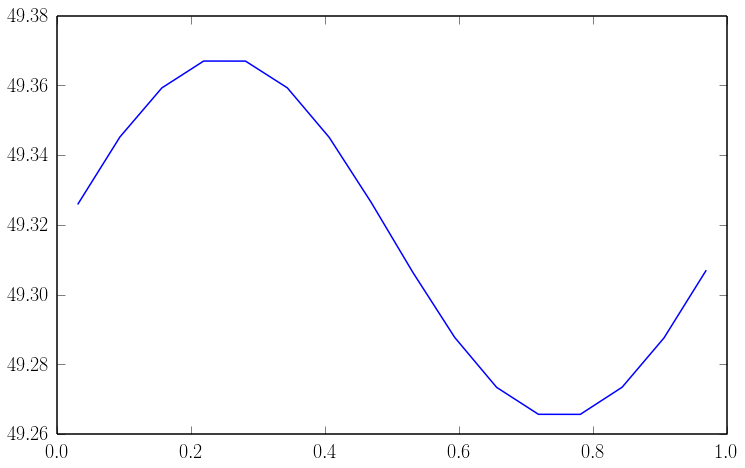

In [20]:
fig, axes = plt.subplots(1)

line1, = axes.plot(xGrid, soln)
#line2, = axes.plot(xGrid, rho0*amplitude*np.cos(k*xGrid))